In [1]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

In [41]:
msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
unc = msfire[:, 2]
flux_spec = msfire[:, 1] * 1e-11 # erg/cm^2/s/A to W/m^2/um (species units)
unc_spec = msfire[:, 2] * 1e-11

smooth_msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118_spex_res_species_units.txt')
w_smooth = smooth_msfire[0, :]
f_smooth = smooth_msfire[1, :] * 1e11
u_smooth = smooth_msfire[2, :]

w_min = w_smooth[0]
w_max = w_smooth[-1]

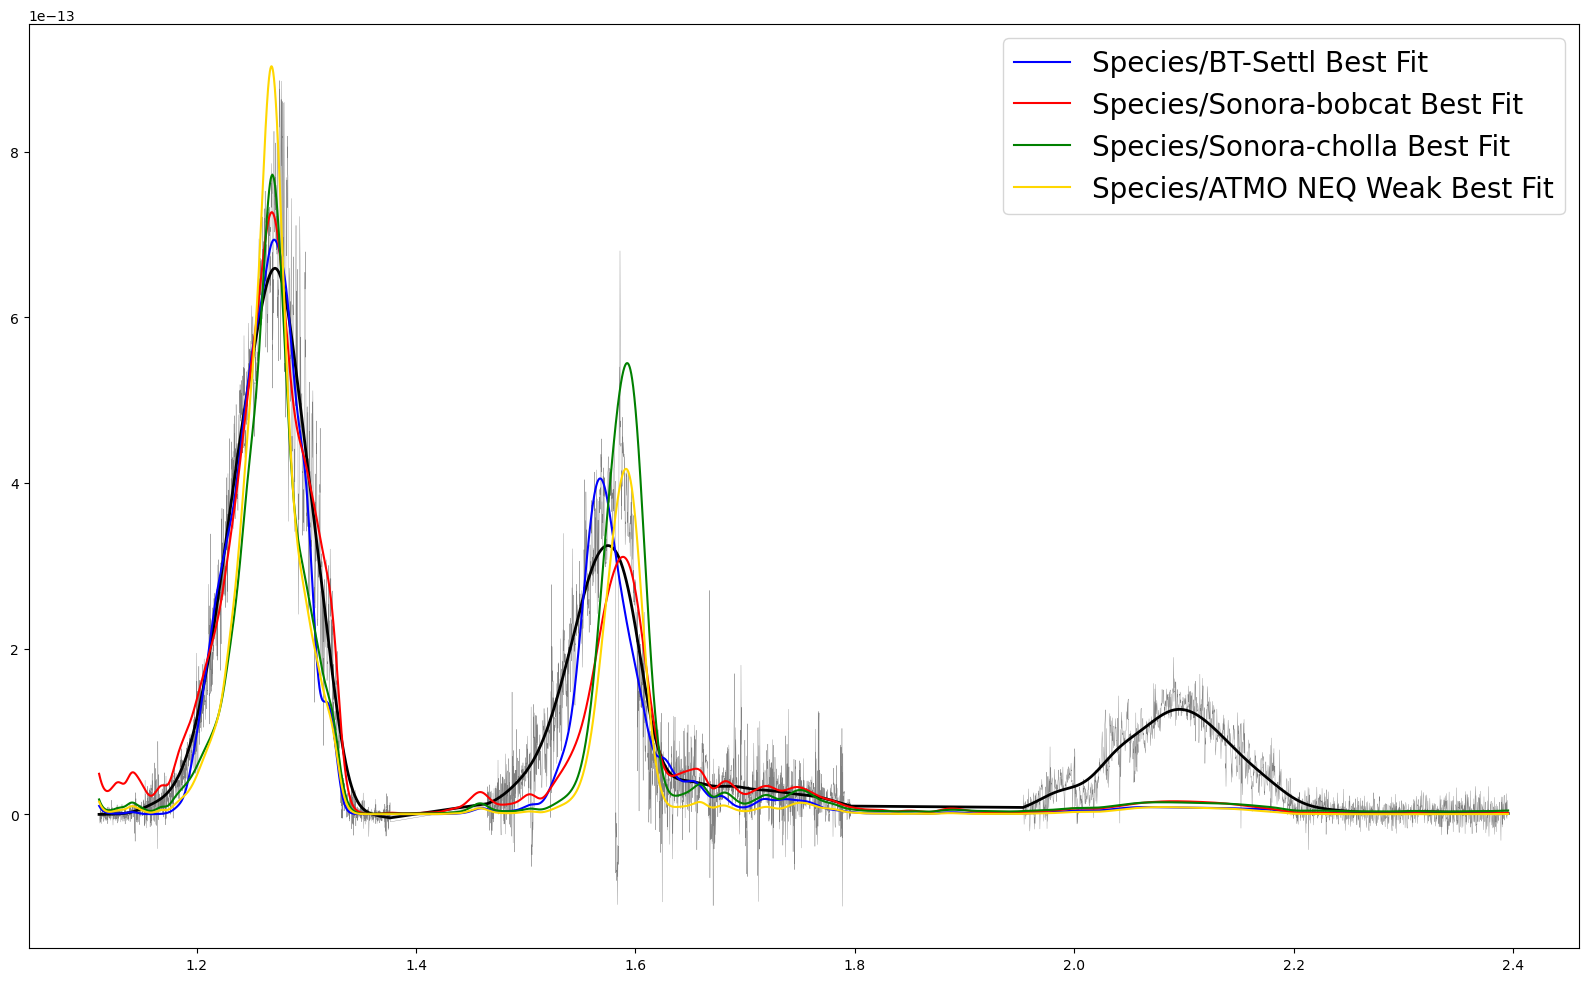

In [76]:
target_short = 'WISE J225540'

spec_bt = np.loadtxt('species_bestfit_bt-settl_model.txt')
bt_w = spec_bt[:, 0]
bt_f = spec_bt[:, 1] * 1e11
bt_mask = (bt_w >= w_min) & (bt_w <= w_max)
bt_wave = bt_w[bt_mask]
bt_flux = bt_f[bt_mask]

spec_btsmooth = np.loadtxt('species_bestfit_bt-settl_spexres_model.txt')
btsmooth_w = spec_btsmooth[:, 0]
btsmooth_f = spec_btsmooth[:, 1] * 1e11
btsmooth_mask = (btsmooth_w >= w_min) & (btsmooth_w <= w_max)
btsmooth_wave = btsmooth_w[btsmooth_mask]
btsmooth_flux = btsmooth_f[btsmooth_mask]

spec_bobcatsmooth = np.loadtxt('species_bestfit_sonora-bobcat_spexres.txt')
bobcatsmooth_w = spec_bobcatsmooth[:, 0]
bobcatsmooth_f = spec_bobcatsmooth[:, 1] * 1e11
bobcatsmooth_mask = (bobcatsmooth_w >= w_min) & (bobcatsmooth_w <= w_max)
bobcatsmooth_wave = bobcatsmooth_w[bobcatsmooth_mask]
bobcatsmooth_flux = bobcatsmooth_f[bobcatsmooth_mask]

spec_chollasmooth = np.loadtxt('species_bestfit_sonora-cholla_spexres.txt')
chollasmooth_w = spec_chollasmooth[:, 0]
chollasmooth_f = spec_chollasmooth[:, 1] * 1e11
chollasmooth_mask = (chollasmooth_w >= w_min) & (chollasmooth_w <= w_max)
chollasmooth_wave = chollasmooth_w[chollasmooth_mask]
chollasmooth_flux = chollasmooth_f[chollasmooth_mask]

spec_atmoNWsmooth = np.loadtxt('species_bestfit_atmo-neq-weak_spexres.txt')
atmoNWsmooth_w = spec_atmoNWsmooth[:, 0]
atmoNWsmooth_f = spec_atmoNWsmooth[:, 1] * 1e11
atmoNWsmooth_mask = (atmoNWsmooth_w >= w_min) & (atmoNWsmooth_w <= w_max)
atmoNWsmooth_wave = atmoNWsmooth_w[atmoNWsmooth_mask]
atmoNWsmooth_flux = atmoNWsmooth_f[atmoNWsmooth_mask]

spec_atmoNSsmooth = np.loadtxt('species_bestfit_atmo-neq-strong_spexres.txt') # wayyyyy off
atmoNSsmooth_w = spec_atmoNSsmooth[:, 0]
atmoNSsmooth_f = spec_atmoNSsmooth[:, 1] * 1e11
atmoNSsmooth_mask = (atmoNSsmooth_w >= w_min) & (atmoNSsmooth_w <= w_max)
atmoNSsmooth_wave = atmoNSsmooth_w[atmoNSsmooth_mask]
atmoNSsmooth_flux = atmoNSsmooth_f[atmoNSsmooth_mask]

plt.figure(figsize = (20, 12))
plt.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
plt.plot(w_smooth, f_smooth, color = 'black', linewidth = 2)
plt.plot(btsmooth_wave, btsmooth_flux, color = 'blue', label = 'Species/BT-Settl Best Fit')
plt.plot(bobcatsmooth_wave, bobcatsmooth_flux, color = 'red', label = 'Species/Sonora-bobcat Best Fit')
plt.plot(chollasmooth_wave, chollasmooth_flux, color = 'green', label = 'Species/Sonora-cholla Best Fit')
plt.plot(atmoNWsmooth_wave, atmoNWsmooth_flux, color = 'gold', label = 'Species/ATMO NEQ Weak Best Fit')
#plt.plot(atmoNSsmooth_wave, atmoNSsmooth_flux, color = 'purple', label = 'Species/ATMO NEQ Strong Best Fit')
plt.legend(loc = 'upper right', fontsize = 20)

In [77]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/1113535342.py:15: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_btmin = np.where(G_bt == G_btmin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/1113535342.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_bt = int(where_G_btmin[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/1113535342.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (De

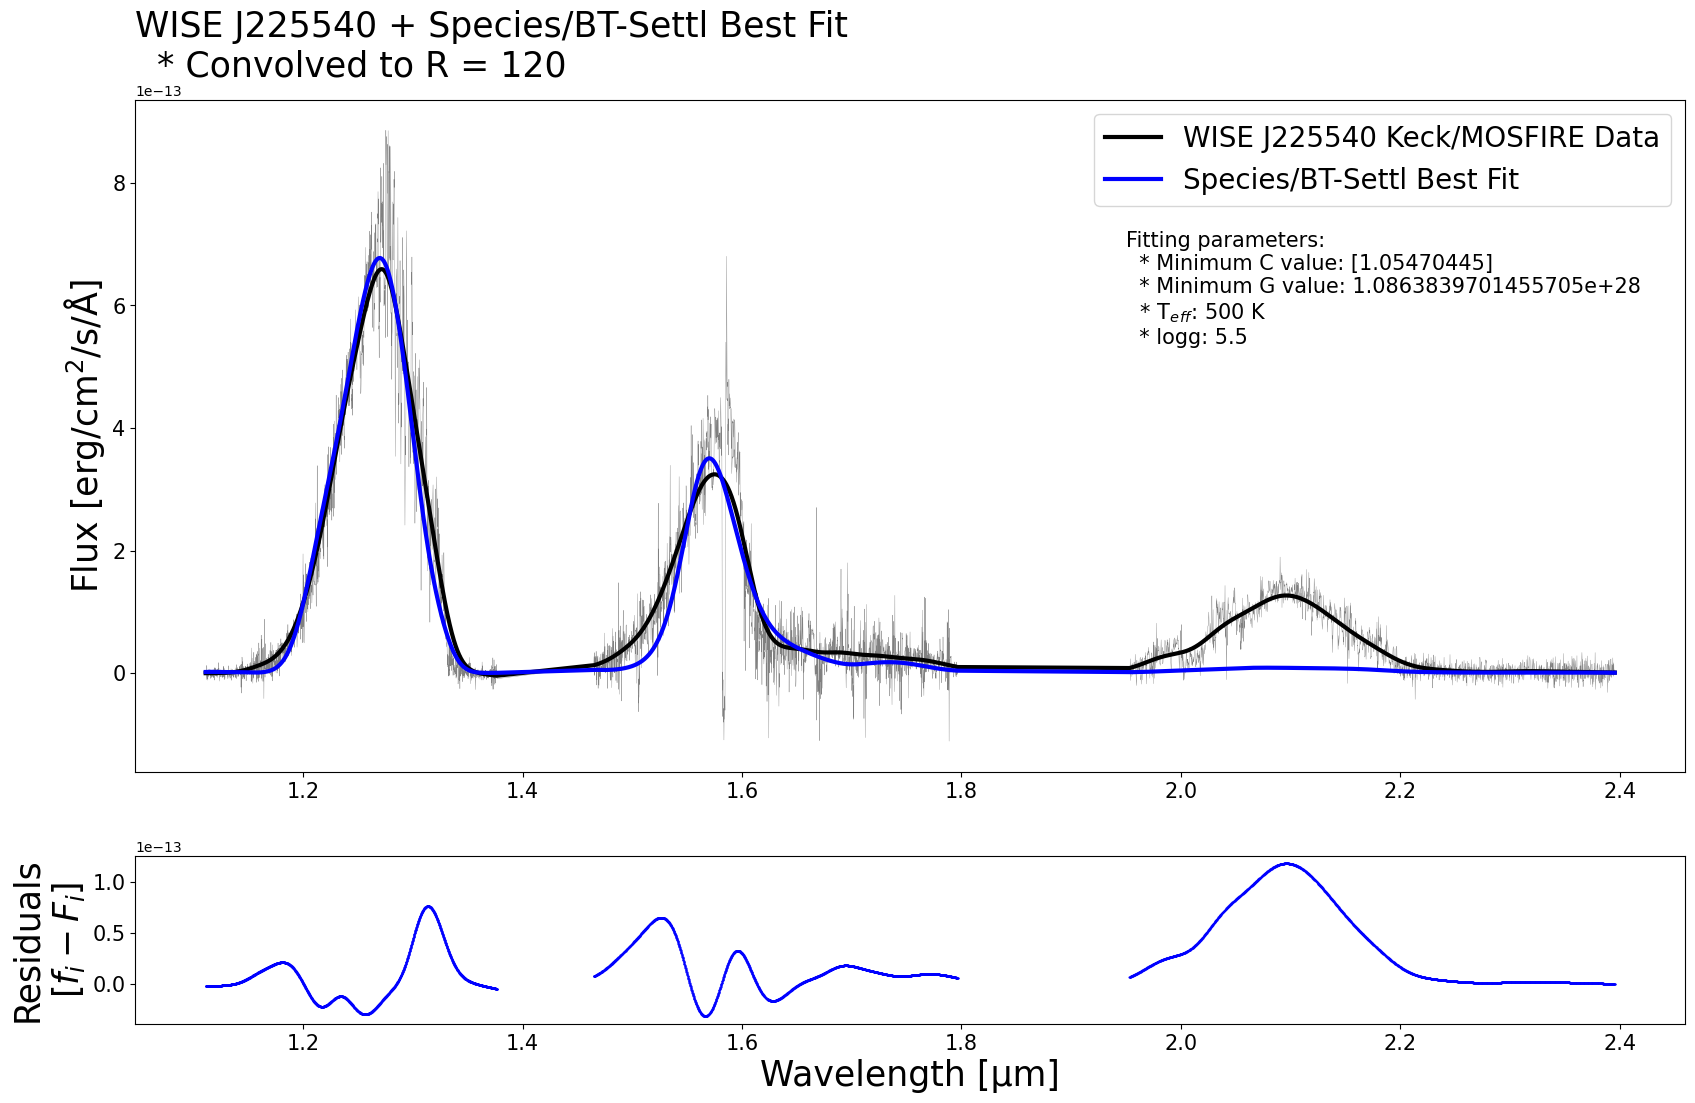

In [118]:
##############################
## Species/BT-Settl Fitting ##
##############################

C_bt = np.zeros(len(btsmooth_wave))
G_bt = np.zeros(len(btsmooth_wave))
low_mod_bt = np.zeros((len(btsmooth_wave), 2, (len(wave_um))))
for i in range(len(btsmooth_wave)):
    interp_bt = np.interp(wave_um, btsmooth_wave, btsmooth_flux)
    range_bt = np.vstack([wave_um, interp_bt])
    low_mod_bt[i, :, :] = convolve_v2(range_bt, 120, 1)
    C_bt[i] = (np.nansum((low_mod_bt[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_bt[i, 1, :] ** 2 / u_smooth ** 2))
G_bt = np.nansum(((f_smooth - low_mod_bt[i, 1, :] * C_bt[i]) / u_smooth) ** 2)
G_btmin = np.min(G_bt)
where_G_btmin = np.where(G_bt == G_btmin)
C_btmin = C_bt[where_G_btmin]
modindex_bt = int(where_G_btmin[0])
residuals_bt = f_smooth - low_mod_bt[int(where_G_btmin[0]), 1, :] * C_btmin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_bt[modindex_bt, 0, :], low_mod_bt[modindex_bt, 1, :] * C_btmin, color = 'blue', linewidth = 3, label = 'Species/BT-Settl Best Fit')
ax1.set_title(f'{target_short} + Species/BT-Settl Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_btmin}\n  * Minimum G value: {G_btmin}\n  * T$_e$$_f$$_f$: 500 K\n  * logg: 5.5\n', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_bt, color = 'blue', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species BT-Settl Best Fit')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/144510910.py:15: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_bobcatmin = np.where(G_bobcat == G_bobcatmin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/144510910.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_bobcat = int(where_G_bobcatmin[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/144510910.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

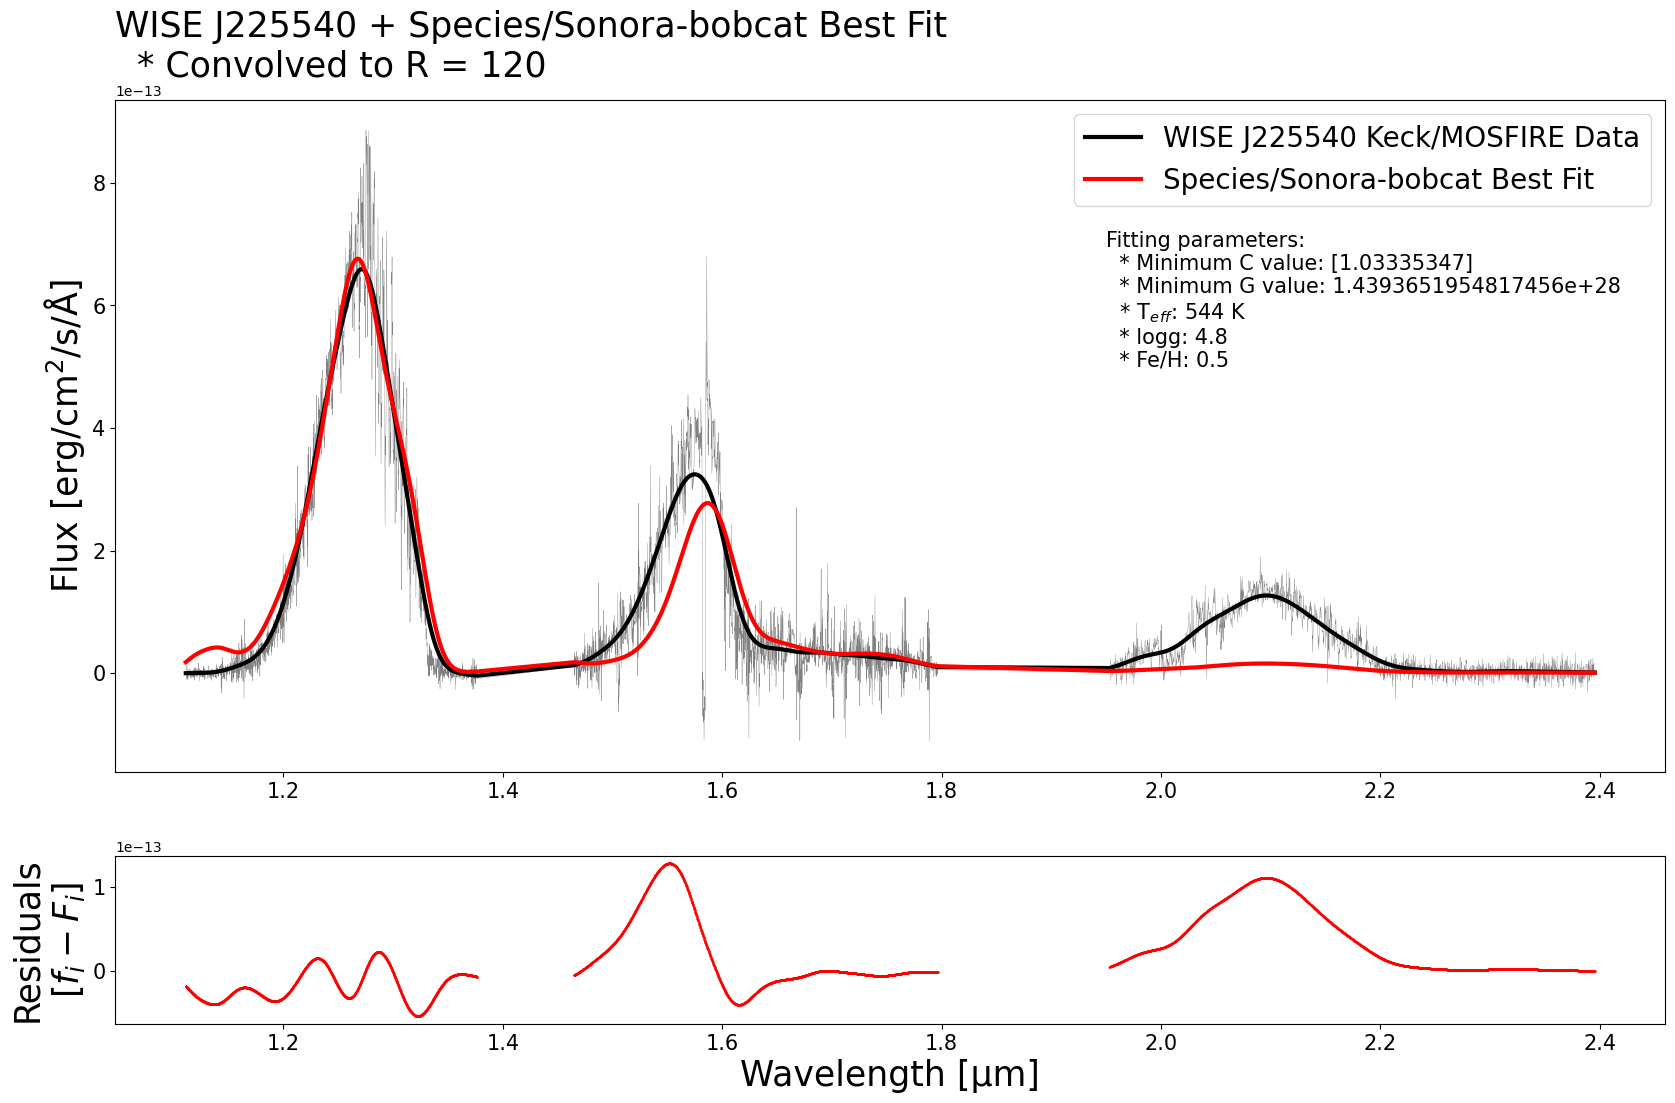

In [117]:
###################################
## Species/Sonora-bobcat Fitting ##
###################################

C_bobcat = np.zeros(len(bobcatsmooth_wave))
G_bobcat = np.zeros(len(bobcatsmooth_wave))
low_mod_bobcat = np.zeros((len(bobcatsmooth_wave), 2, (len(wave_um))))
for i in range(len(bobcatsmooth_wave)):
    interp_bobcat = np.interp(wave_um, bobcatsmooth_wave, bobcatsmooth_flux)
    range_bobcat = np.vstack([wave_um, interp_bobcat])
    low_mod_bobcat[i, :, :] = convolve_v2(range_bobcat, 120, 1)
    C_bobcat[i] = (np.nansum((low_mod_bobcat[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_bobcat[i, 1, :] ** 2 / u_smooth ** 2))
G_bobcat = np.nansum(((f_smooth - low_mod_bobcat[i, 1, :] * C_bobcat[i]) / u_smooth) ** 2)
G_bobcatmin = np.min(G_bobcat)
where_G_bobcatmin = np.where(G_bobcat == G_bobcatmin)
C_bobcatmin = C_bobcat[where_G_bobcatmin]
modindex_bobcat = int(where_G_bobcatmin[0])
residuals_bobcat = f_smooth - low_mod_bobcat[int(where_G_bobcatmin[0]), 1, :] * C_bobcatmin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_bobcat[modindex_bobcat, 0, :], low_mod_bobcat[modindex_bobcat, 1, :] * C_bobcatmin, color = 'red', linewidth = 3, label = 'Species/Sonora-bobcat Best Fit')
ax1.set_title(f'{target_short} + Species/Sonora-bobcat Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_bobcatmin}\n  * Minimum G value: {G_bobcatmin}\n  * T$_e$$_f$$_f$: 544 K\n  * logg: 4.8\n  * Fe/H: 0.5', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_bobcat, color = 'red', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species Sonora-bobcat Best Fit')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/783640733.py:15: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_chollamin = np.where(G_cholla == G_chollamin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/783640733.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_cholla = int(where_G_chollamin[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/783640733.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing th

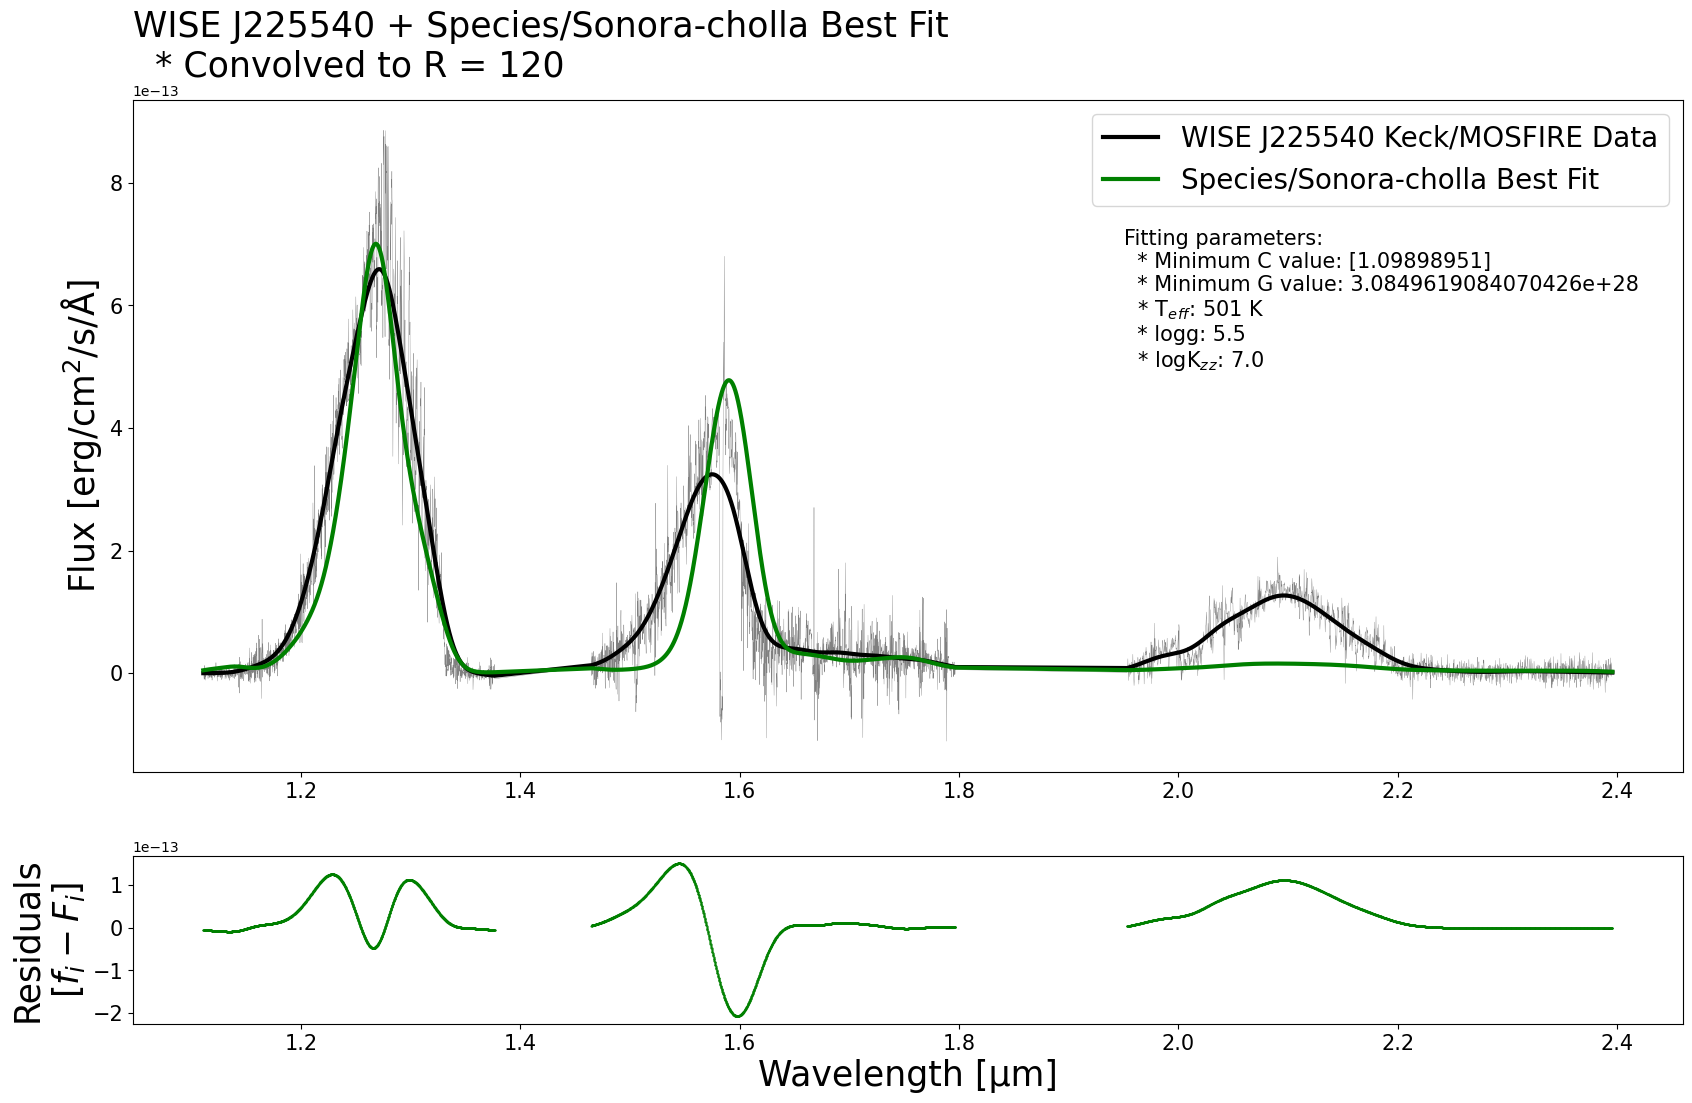

In [116]:
###################################
## Species/Sonora-cholla Fitting ##
###################################

C_cholla = np.zeros(len(chollasmooth_wave))
G_cholla = np.zeros(len(chollasmooth_wave))
low_mod_cholla = np.zeros((len(chollasmooth_wave), 2, (len(wave_um))))
for i in range(len(chollasmooth_wave)):
    interp_cholla = np.interp(wave_um, chollasmooth_wave, chollasmooth_flux)
    range_cholla = np.vstack([wave_um, interp_cholla])
    low_mod_cholla[i, :, :] = convolve_v2(range_cholla, 120, 1)
    C_cholla[i] = (np.nansum((low_mod_cholla[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_cholla[i, 1, :] ** 2 / u_smooth ** 2))
G_cholla = np.nansum(((f_smooth - low_mod_cholla[i, 1, :] * C_cholla[i]) / u_smooth) ** 2)
G_chollamin = np.min(G_cholla)
where_G_chollamin = np.where(G_cholla == G_chollamin)
C_chollamin = C_cholla[where_G_chollamin]
modindex_cholla = int(where_G_chollamin[0])
residuals_cholla = f_smooth - low_mod_cholla[int(where_G_chollamin[0]), 1, :] * C_chollamin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_cholla[modindex_cholla, 0, :], low_mod_cholla[modindex_cholla, 1, :] * C_chollamin, color = 'green', linewidth = 3, label = 'Species/Sonora-cholla Best Fit')
ax1.set_title(f'{target_short} + Species/Sonora-cholla Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_chollamin}\n  * Minimum G value: {G_chollamin}\n  * T$_e$$_f$$_f$: 501 K\n  * logg: 5.5\n  * logK$_z$$_z$: 7.0', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_cholla, color = 'green', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species Sonora-cholla Best Fit')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/3588215351.py:15: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_atmoNWmin = np.where(G_atmoNW == G_atmoNWmin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/3588215351.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_atmoNW = int(where_G_atmoNWmin[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/3588215351.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing

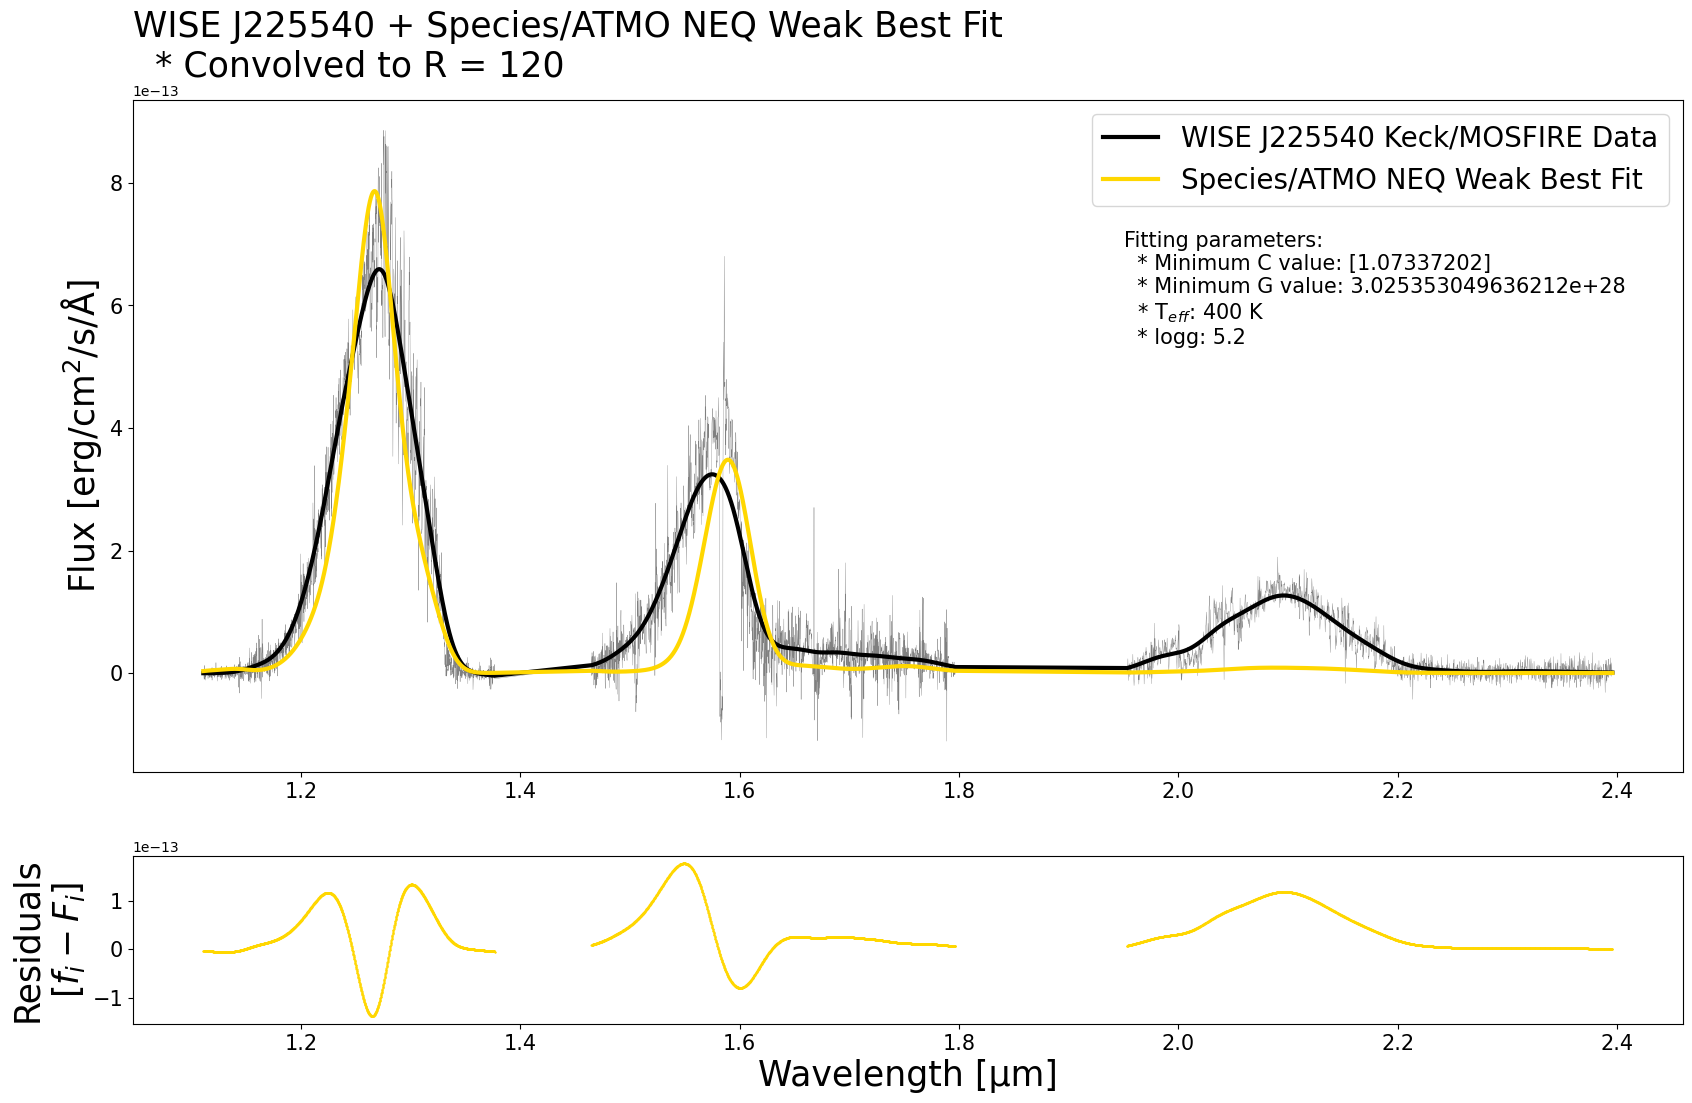

In [114]:
####################################
## Species/ATMO NEQ Weak Fitting ##
####################################

C_atmoNW = np.zeros(len(atmoNWsmooth_wave))
G_atmoNW = np.zeros(len(atmoNWsmooth_wave))
low_mod_atmoNW = np.zeros((len(atmoNWsmooth_wave), 2, (len(wave_um))))
for i in range(len(atmoNWsmooth_wave)):
    interp_atmoNW = np.interp(wave_um, atmoNWsmooth_wave, atmoNWsmooth_flux)
    range_atmoNW = np.vstack([wave_um, interp_atmoNW])
    low_mod_atmoNW[i, :, :] = convolve_v2(range_atmoNW, 120, 1)
    C_atmoNW[i] = (np.nansum((low_mod_atmoNW[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_atmoNW[i, 1, :] ** 2 / u_smooth ** 2))
G_atmoNW = np.nansum(((f_smooth - low_mod_atmoNW[i, 1, :] * C_atmoNW[i]) / u_smooth) ** 2)
G_atmoNWmin = np.min(G_atmoNW)
where_G_atmoNWmin = np.where(G_atmoNW == G_atmoNWmin)
C_atmoNWmin = C_atmoNW[where_G_atmoNWmin]
modindex_atmoNW = int(where_G_atmoNWmin[0])
residuals_atmoNW = f_smooth - low_mod_atmoNW[int(where_G_atmoNWmin[0]), 1, :] * C_atmoNWmin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_atmoNW[modindex_atmoNW, 0, :], low_mod_atmoNW[modindex_atmoNW, 1, :] * C_atmoNWmin, color = 'gold', linewidth = 3, label = 'Species/ATMO NEQ Weak Best Fit')
ax1.set_title(f'{target_short} + Species/ATMO NEQ Weak Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_atmoNWmin}\n  * Minimum G value: {G_atmoNWmin}\n  * T$_e$$_f$$_f$: 400 K\n  * logg: 5.2\n', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_atmoNW, color = 'gold', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species ATMO NEQ Weak Best Fit')

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/2048817377.py:15: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_atmoNSmin = np.where(G_atmoNS == G_atmoNSmin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/2048817377.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_atmoNS = int(where_G_atmoNSmin[0])
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_58697/2048817377.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing

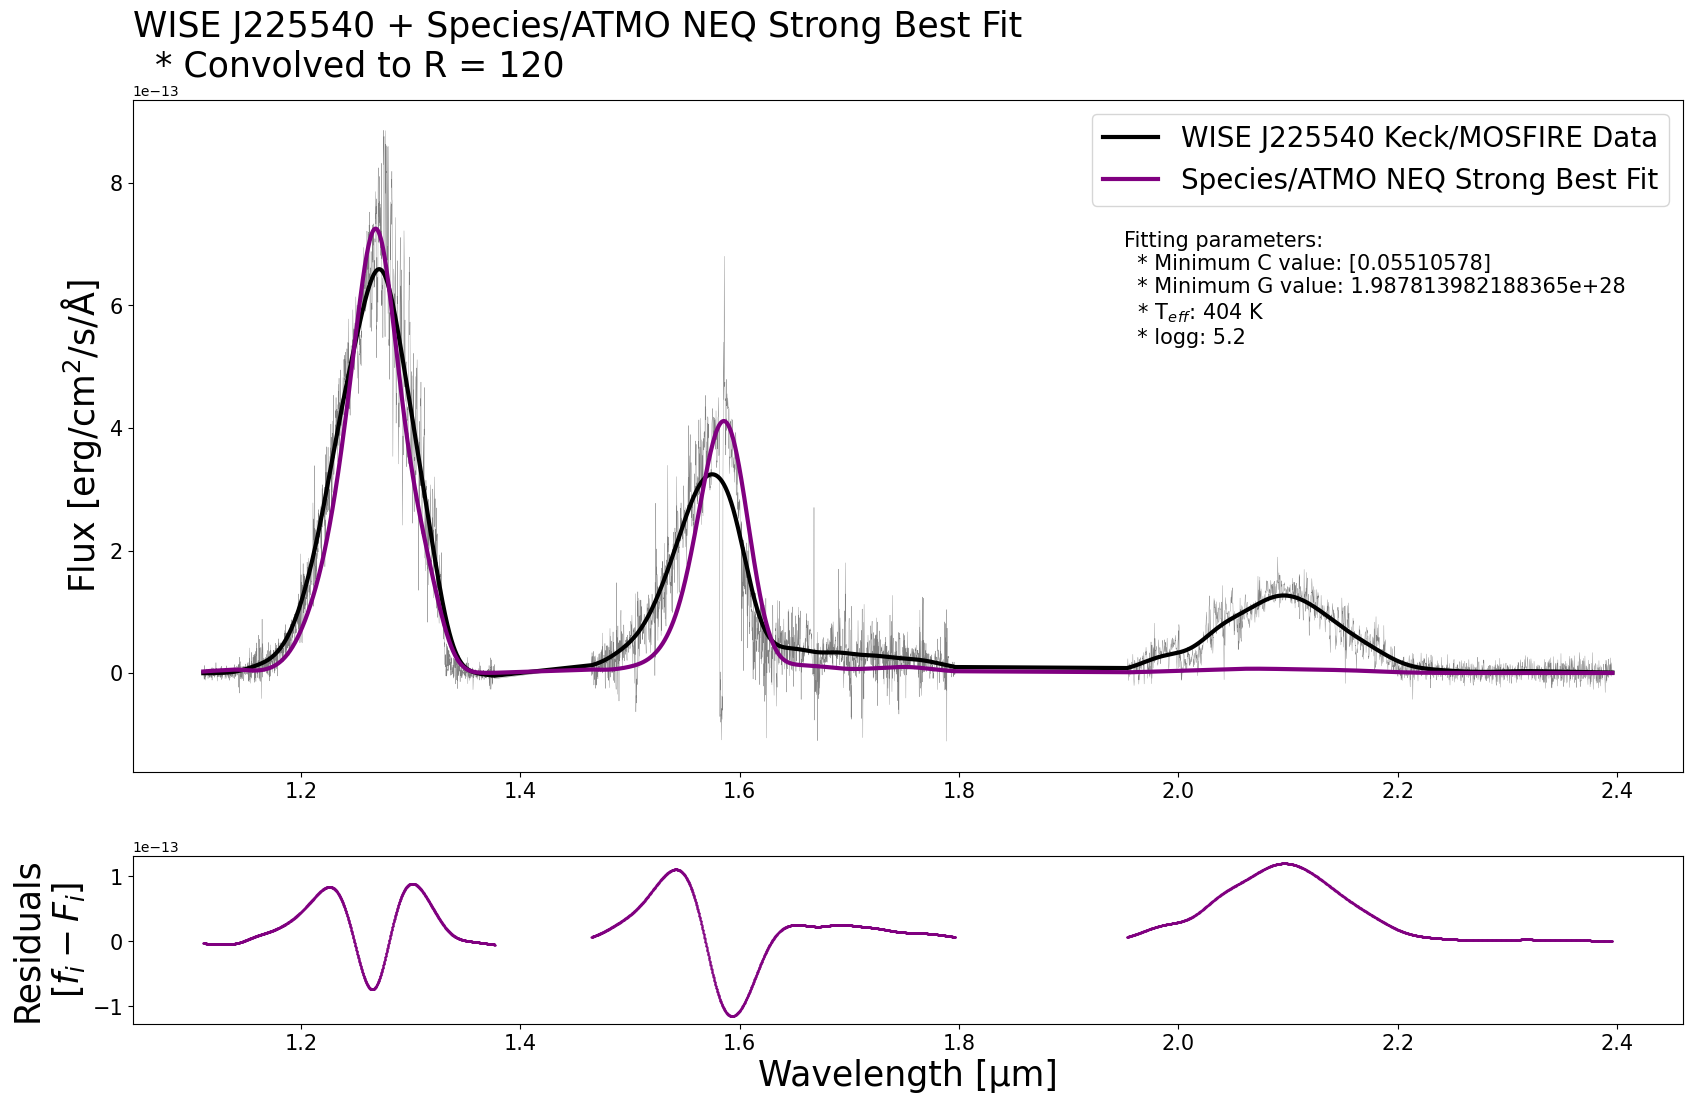

In [115]:
#####################################
## Species/ATMO NEQ Strong Fitting ##
#####################################

C_atmoNS = np.zeros(len(atmoNSsmooth_wave))
G_atmoNS = np.zeros(len(atmoNSsmooth_wave))
low_mod_atmoNS = np.zeros((len(atmoNSsmooth_wave), 2, (len(wave_um))))
for i in range(len(atmoNSsmooth_wave)):
    interp_atmoNS = np.interp(wave_um, atmoNSsmooth_wave, atmoNSsmooth_flux)
    range_atmoNS = np.vstack([wave_um, interp_atmoNS])
    low_mod_atmoNS[i, :, :] = convolve_v2(range_atmoNS, 120, 1)
    C_atmoNS[i] = (np.nansum((low_mod_atmoNS[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_atmoNS[i, 1, :] ** 2 / u_smooth ** 2))
G_atmoNS = np.nansum(((f_smooth - low_mod_atmoNS[i, 1, :] * C_atmoNS[i]) / u_smooth) ** 2)
G_atmoNSmin = np.min(G_atmoNS)
where_G_atmoNSmin = np.where(G_atmoNS == G_atmoNSmin)
C_atmoNSmin = C_atmoNS[where_G_atmoNSmin]
modindex_atmoNS = int(where_G_atmoNSmin[0])
residuals_atmoNS = f_smooth - low_mod_atmoNS[int(where_G_atmoNSmin[0]), 1, :] * C_atmoNSmin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_atmoNS[modindex_atmoNS, 0, :], low_mod_atmoNS[modindex_atmoNS, 1, :] * C_atmoNSmin, color = 'purple', linewidth = 3, label = 'Species/ATMO NEQ Strong Best Fit')
ax1.set_title(f'{target_short} + Species/ATMO NEQ Strong Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_atmoNSmin}\n  * Minimum G value: {G_atmoNSmin}\n  * T$_e$$_f$$_f$: 404 K\n  * logg: 5.2\n', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_atmoNS, color = 'purple', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species ATMO NEQ Strong Best Fit')

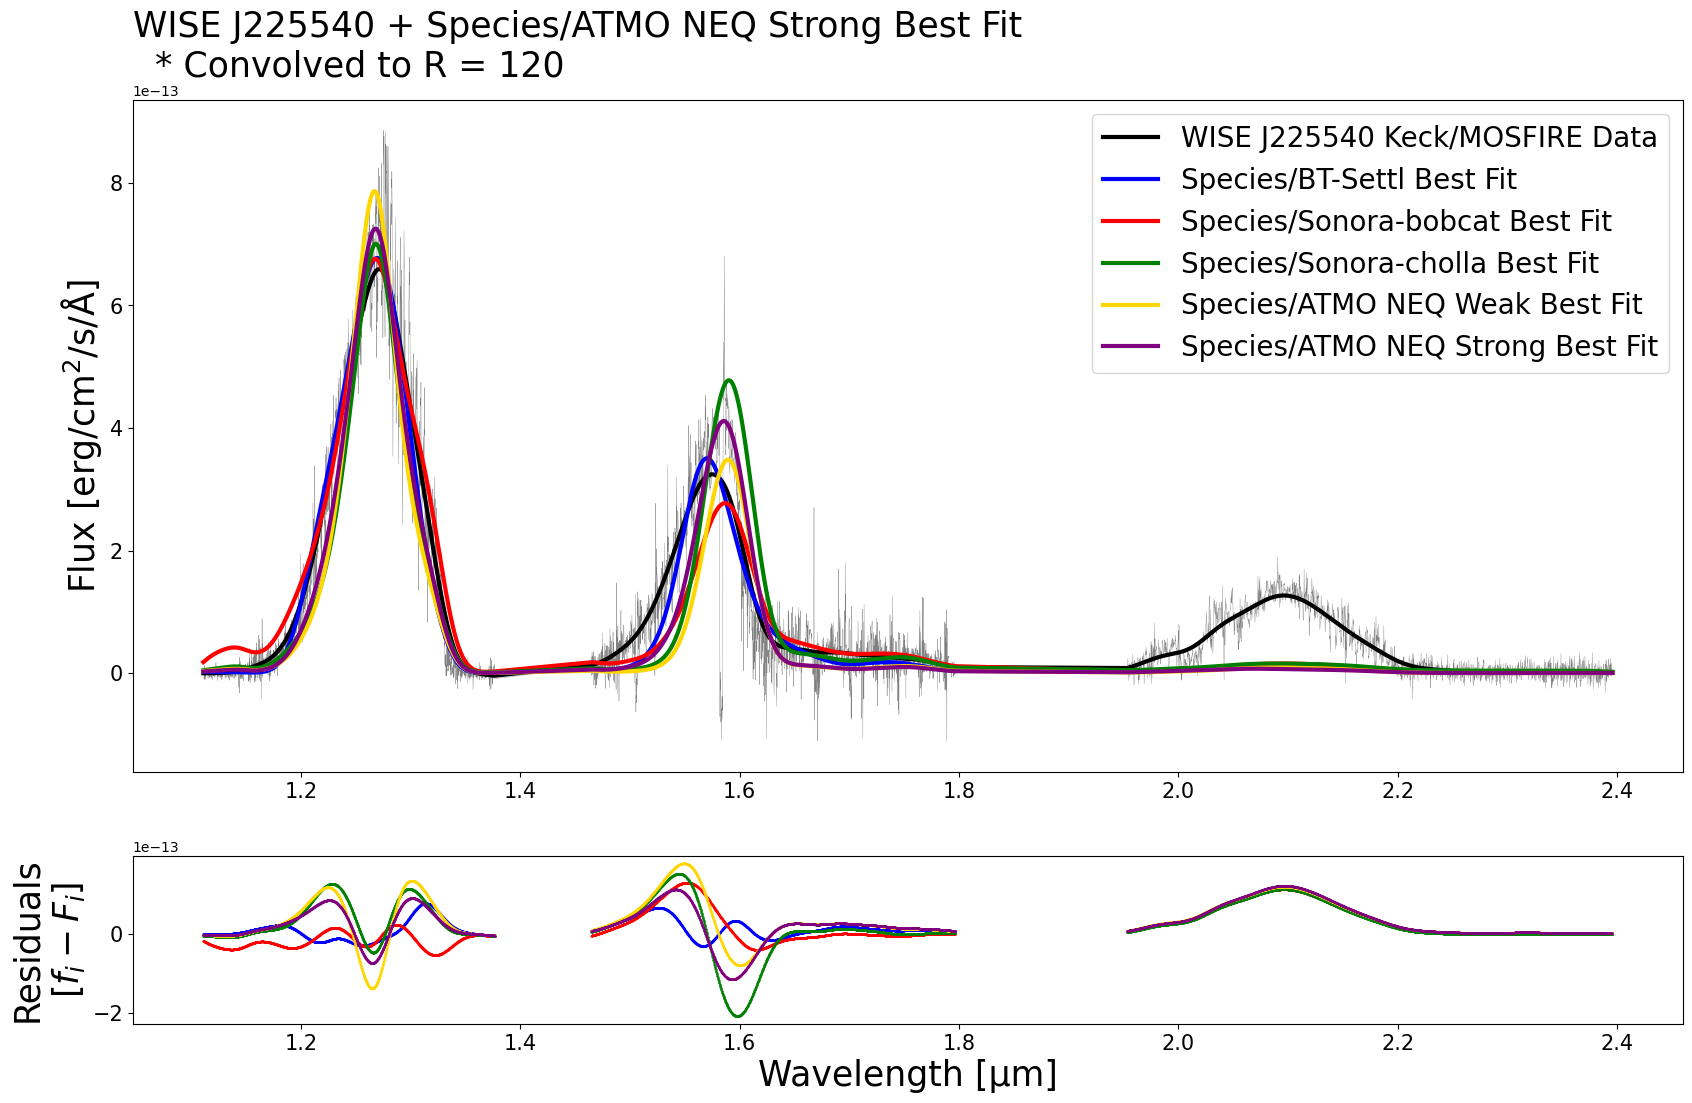

In [111]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_bt[modindex_bt, 0, :], low_mod_bt[modindex_bt, 1, :] * C_btmin, color = 'blue', linewidth = 3, label = 'Species/BT-Settl Best Fit')
ax1.plot(low_mod_bobcat[modindex_bobcat, 0, :], low_mod_bobcat[modindex_bobcat, 1, :] * C_bobcatmin, color = 'red', linewidth = 3, label = 'Species/Sonora-bobcat Best Fit')
ax1.plot(low_mod_cholla[modindex_cholla, 0, :], low_mod_cholla[modindex_cholla, 1, :] * C_chollamin, color = 'green', linewidth = 3, label = 'Species/Sonora-cholla Best Fit')
ax1.plot(low_mod_atmoNW[modindex_atmoNW, 0, :], low_mod_atmoNW[modindex_atmoNW, 1, :] * C_atmoNWmin, color = 'gold', linewidth = 3, label = 'Species/ATMO NEQ Weak Best Fit')
ax1.plot(low_mod_atmoNS[modindex_atmoNS, 0, :], low_mod_atmoNS[modindex_atmoNS, 1, :] * C_atmoNSmin, color = 'purple', linewidth = 3, label = 'Species/ATMO NEQ Strong Best Fit')
ax1.set_title(f'{target_short} + Species/ATMO NEQ Strong Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
#ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_atmoNSmin}\n  * Minimum G value: {G_atmoNSmin}\n  * T$_e$$_f$$_f$: 404 K\n  * logg: 5.2\n', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_bt, color = 'blue', marker = '.', s = 1)
ax2.scatter(w_smooth, residuals_bobcat, color = 'red', marker = '.', s = 1)
ax2.scatter(w_smooth, residuals_cholla, color = 'green', marker = '.', s = 1)
ax2.scatter(w_smooth, residuals_atmoNW, color = 'gold', marker = '.', s = 1)
ax2.scatter(w_smooth, residuals_atmoNS, color = 'purple', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Species Best Fits v1')